# Working With Feature Rich Dataset

## Load Dataset

In [1]:
import HelperFuncs as hfuncs
import os
import h5py
import numpy as np

#Bucket with clean data
key_id, secret_key = hfuncs.GetAWSCredentials()
client = hfuncs.GetAWSClient(key_id,secret_key)
bucket = client.Bucket(hfuncs.CLEAN_DATA_BUCKET)

# Grab train data
# Download dataset
print("Downloading train dataset...")
mode = 'train'
key_suffix = "{}_data.hdf5".format(mode)
filename = os.path.join(hfuncs.TEMP_DIR,key_suffix)
key = "{}/{}".format(hfuncs.CLEAN_DATA_DIR,key_suffix)

if not os.path.exists(filename):
    bucket.download_file(Key=key,Filename=filename)

# Open downloaded file and load data
with h5py.File(filename,"r") as f:    
    #Get train data
    print("Reading data...")
    
    d = f['/features']
    X_train = d[:]
  
    d = f['/labels']
    y_train = d[:]

# Grab val data
# Download dataset
print("Downloading val dataset...")
mode = 'val'
key_suffix = "{}_data.hdf5".format(mode)
filename = os.path.join(hfuncs.TEMP_DIR,key_suffix)
key = "{}/{}".format(hfuncs.CLEAN_DATA_DIR,key_suffix)

if not os.path.exists(filename):
    bucket.download_file(Key=key,Filename=filename)
    
# Open downloaded file and load data
with h5py.File(filename,"r") as f:    
    #Get train data
    print("Reading data...")
    
    d = f['/features']
    X_val = d[:]
  
    d = f['/labels']
    y_val = d[:]
    
print("Data loaded!")
print("Data Shape:",X_train.shape)

Reading data...
Reading data...
Data loaded!
Data Shape: (891, 128000)


## Unsupervised Examination

In [2]:
print("{} Total Samples.".format(len(y_train)))
print("{0} Total positives, corresponding to {1:.1f}% of the data".format(sum(y_train),sum(y_train)*100/len(y_train)))


891 Total Samples.
544.0 Total positives, corresponding to 61.1% of the data


### t-SNE Plot

Fit model for perplexity 2
Fit model for perplexity 5
Fit model for perplexity 30
Fit model for perplexity 50
Fit model for perplexity 100


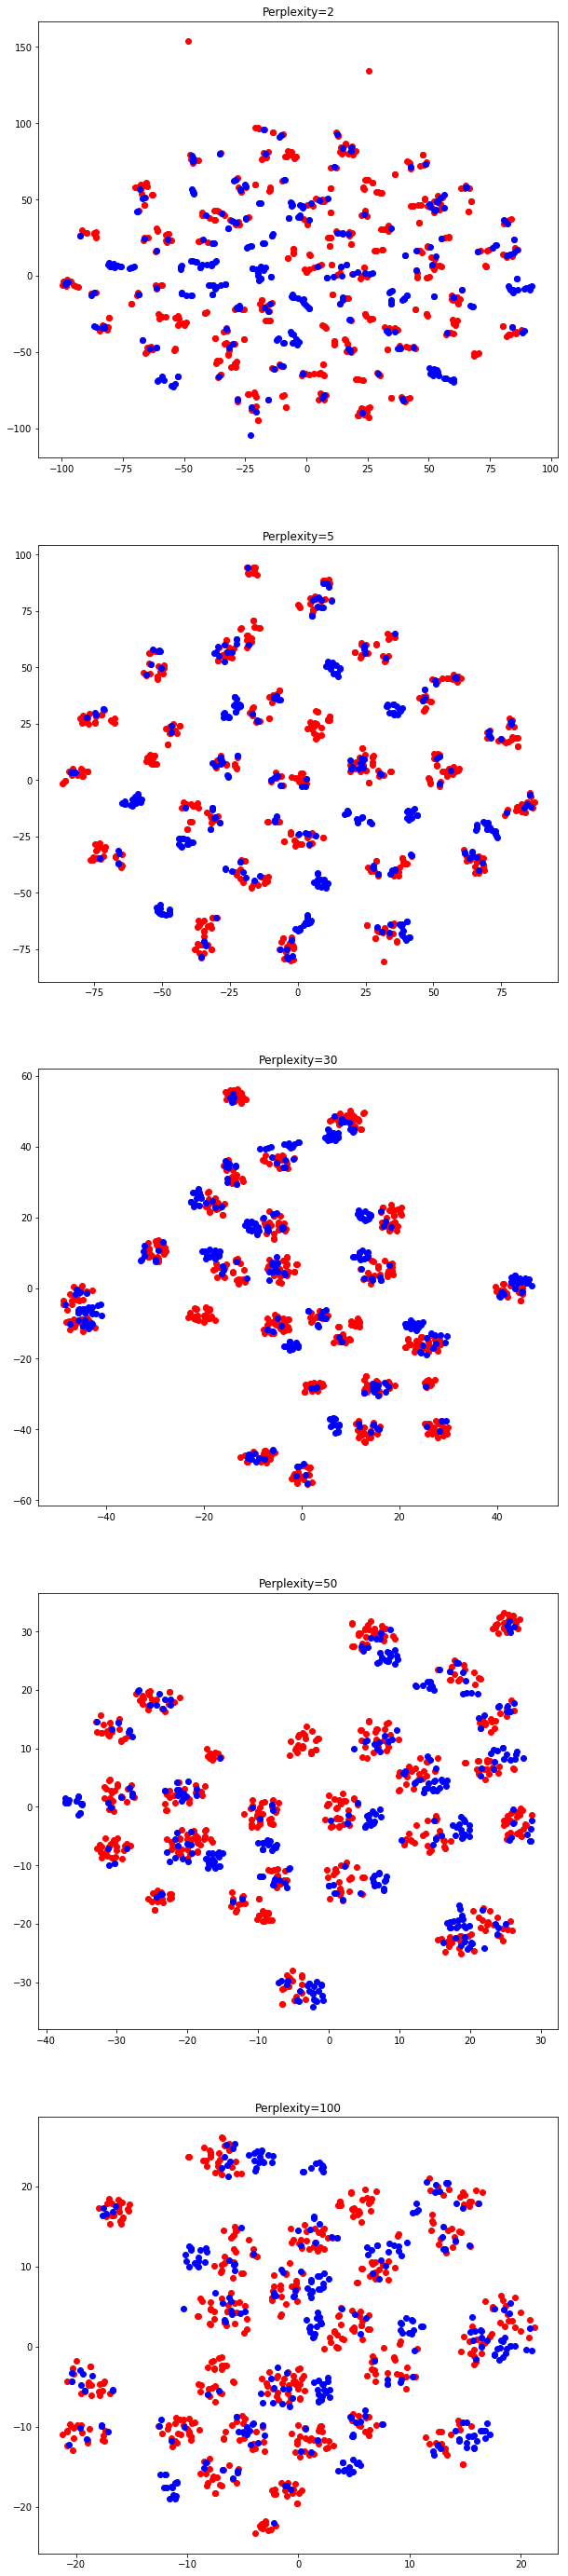

In [16]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
% matplotlib inline

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
perplexity = [2,5,30,50,100]

fig, axes = plt.subplots(5,1,figsize=(10,50))

red = y_train == 1
blue = y_train == 0

i = 0
for p in perplexity:
    # Fit t-SNE
    tsne = TSNE(perplexity = p, random_state = 0)
    X_t = tsne.fit_transform(X_train_s)
    print("Fit model for perplexity {}.".format(p))
    
    # Plot
    ax = axes[i]
    ax.set_title("Perplexity=%d" % p)
    ax.scatter(X_t[red,0],X_t[red,1],c='r')
    ax.scatter(X_t[blue,0],X_t[blue,1],c='b')
    
    i+=1
    
    

From the t-SNE plots above we see that the new features enable some separation between those samples contatining threats and those not containing them.  Notice in the p=100 plot several pure blue and red clusters.  There are some clouds with a lot of overlap, but hopefully a non-linear approach might be able to achieve a good separation of the classes. These results are reassuring of the usefulness of using the pre-trained INceptionV3 network as  a feature extractor. 

## Gradient Boosted Classifier 

In [2]:
from imblearn.over_sampling import RandomOverSampler

# Balance classes
ros = RandomOverSampler(random_state=0)
X_train,y_train = ros.fit_sample(X_train,y_train)

In [24]:
print("{} Total Samples.".format(len(y_train)))
print("{0} Total positives, corresponding to {1:.1f}% of the data".format(sum(y_train),sum(y_train)*100/len(y_train)))

1088 Total Samples.
544.0 Total positives, corresponding to 50.0% of the data


## Trial 1

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss,accuracy_score,f1_score
from sklearn.metrics import precision_recall_fscore_support

# Retrain using best params
gbc = GradientBoostingClassifier(random_state=0,max_features=None,n_estimators=100,subsample=0.8,verbose=2)
gbc.fit(X_train,y_train)

# Make predictions
y_val_pred = gbc.predict(X_val)
y_val_proba = gbc.predict_proba(X_val)
y_train_pred = gbc.predict(X_train)
y_train_proba = gbc.predict_proba(X_train)

# Validation scores
logl = log_loss(y_val,y_val_proba)
p,r,f,s = precision_recall_fscore_support(y_val,y_val_pred)
acc = accuracy_score(y_val,y_val_pred)
print("Validation Scores:")
print("Log-Loss: {}".format(logl))
print("Positive Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[1],r[1],f[1],s[1]))
print("Negative Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[0],r[0],f[0],s[0]))
print("Accuracy: {}\n".format(acc))

# Training Scores
logl = log_loss(y_train,y_train_proba)
p,r,f,s = precision_recall_fscore_support(y_train,y_train_pred)
acc = accuracy_score(y_train,y_train_pred)
print("Training Scores:")
print("Log-Loss: {}".format(logl))
print("Positive Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[1],r[1],f[1],s[1]))
print("Negative Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[0],r[0],f[0],s[0]))
print("Accuracy: {}".format(acc))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3087           0.0532           20.60m
         2           1.2422           0.0422           20.39m
         3           1.1833           0.0363           20.23m
         4           1.1365           0.0312           19.99m
         5           1.0864           0.0277           19.79m
         6           1.0531           0.0306           19.58m
         7           1.0193           0.0229           19.35m
         8           0.9802           0.0239           19.13m
         9           0.9554           0.0150           18.93m
        10           0.9079           0.0110           18.72m
        11           0.8877           0.0166           18.48m
        12           0.8581           0.0127           18.29m
        13           0.8419           0.0133           18.06m
        14           0.8177           0.0124           17.85m
        15           0.7813           0.0086           17.65m
       

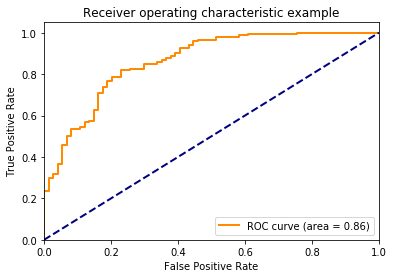

In [53]:
from sklearn.metrics import roc_curve,auc
from matplotlib import pyplot as plt

fpr,tpr,thresholds = roc_curve(y_val,y_val_proba[:,1],drop_intermediate=False)
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Of 128000 features, 615 are important


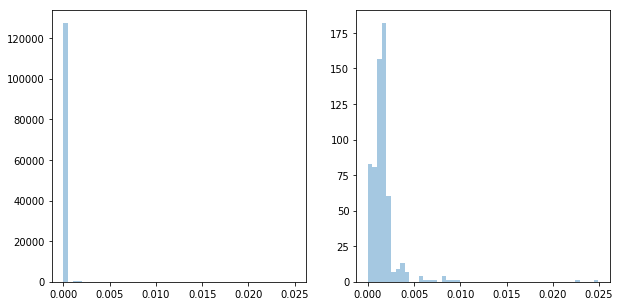

In [54]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

fig,axes = plt.subplots(1,2,figsize=(10,5))

sns.distplot(gbc.feature_importances_,kde=False,ax=axes[0])
sns.distplot(gbc.feature_importances_[gbc.feature_importances_ > 0],kde=False,ax=axes[1])

importance_idx = gbc.feature_importances_ > 0

#Store results so that we don't lose this data again
with h5py.File("feature_data.hdf5","w") as f:
    dset = f.create_dataset("importance_idx",data=importance_idx)
    dset2 = f.create_dataset("feature_importances",data=gbc.feature_importances_)

print("Of {} features, {} are important".format(len(gbc.feature_importances_),sum(importance_idx)))


## Trial 2

In [55]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss,accuracy_score,f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedShuffleSplit,GridSearchCV
from sklearn.metrics import make_scorer

# Cross validation of gradient boosted tree classifier
gbc = GradientBoostingClassifier(random_state=0,max_features=307)
scorer = make_scorer(log_loss,greater_is_better=False,needs_proba=True)


estimators_range = [200,500,1000]
lr_range = [0.01,0.05,0.1]
subsample_range = [0.25,0.5,0.75,0.8,1]
max_depth_range = [3,5]
param_grid = {'n_estimators':estimators_range,'learning_rate':lr_range,
             'subsample':subsample_range,'max_depth':max_depth_range}
cv = StratifiedShuffleSplit(n_splits=3,test_size = 0.2,random_state = 0)
grid = GridSearchCV(gbc,param_grid=param_grid,cv=cv,n_jobs=7,verbose=2,scoring=scorer)

grid.fit(X_train[:,importance_idx],y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))



Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV] learning_rate=0.01, n_estimators=200, subsample=0.25, max_depth=3 
[CV] learning_rate=0.01, n_estimators=200, subsample=0.25, max_depth=3 
[CV] learning_rate=0.01, n_estimators=200, subsample=0.25, max_depth=3 
[CV] learning_rate=0.01, n_estimators=200, subsample=0.5, max_depth=3 
[CV] learning_rate=0.01, n_estimators=200, subsample=0.5, max_depth=3 
[CV] learning_rate=0.01, n_estimators=200, subsample=0.75, max_depth=3 
[CV] learning_rate=0.01, n_estimators=200, subsample=0.5, max_depth=3 
[CV]  learning_rate=0.01, n_estimators=200, subsample=0.25, max_depth=3, total=   2.3s
[CV] learning_rate=0.01, n_estimators=200, subsample=0.75, max_depth=3 
[CV]  learning_rate=0.01, n_estimators=200, subsample=0.25, max_depth=3, total=   2.5s
[CV] learning_rate=0.01, n_estimators=200, subsample=0.75, max_depth=3 
[CV]  learning_rate=0.01, n_estimators=200, subsample=0.25, max_depth=3, total=   2.6s
[CV] learning_rate=0.01, n_estim

[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   34.2s


[CV]  learning_rate=0.01, n_estimators=500, subsample=1, max_depth=3, total=  13.6s
[CV] learning_rate=0.01, n_estimators=1000, subsample=0.5, max_depth=3 
[CV]  learning_rate=0.01, n_estimators=1000, subsample=0.25, max_depth=3, total=  11.7s
[CV] learning_rate=0.01, n_estimators=1000, subsample=0.5, max_depth=3 
[CV]  learning_rate=0.01, n_estimators=1000, subsample=0.25, max_depth=3, total=  11.4s
[CV] learning_rate=0.01, n_estimators=1000, subsample=0.75, max_depth=3 
[CV]  learning_rate=0.01, n_estimators=500, subsample=1, max_depth=3, total=  16.0s
[CV] learning_rate=0.01, n_estimators=1000, subsample=0.75, max_depth=3 
[CV]  learning_rate=0.01, n_estimators=500, subsample=1, max_depth=3, total=  17.0s
[CV] learning_rate=0.01, n_estimators=1000, subsample=0.75, max_depth=3 
[CV]  learning_rate=0.01, n_estimators=1000, subsample=0.25, max_depth=3, total=  12.5s
[CV] learning_rate=0.01, n_estimators=1000, subsample=0.8, max_depth=3 
[CV]  learning_rate=0.01, n_estimators=1000, subs

[CV]  learning_rate=0.01, n_estimators=1000, subsample=0.5, max_depth=5, total=  33.4s
[CV] learning_rate=0.01, n_estimators=1000, subsample=0.8, max_depth=5 
[CV]  learning_rate=0.01, n_estimators=1000, subsample=0.5, max_depth=5, total=  38.2s
[CV] learning_rate=0.01, n_estimators=1000, subsample=1, max_depth=5 .
[CV]  learning_rate=0.01, n_estimators=1000, subsample=0.75, max_depth=5, total=  47.3s
[CV] learning_rate=0.01, n_estimators=1000, subsample=1, max_depth=5 .
[CV]  learning_rate=0.01, n_estimators=1000, subsample=0.75, max_depth=5, total=  47.1s
[CV] learning_rate=0.01, n_estimators=1000, subsample=1, max_depth=5 .
[CV]  learning_rate=0.01, n_estimators=1000, subsample=0.75, max_depth=5, total=  51.7s
[CV] learning_rate=0.05, n_estimators=200, subsample=0.25, max_depth=3 
[CV]  learning_rate=0.05, n_estimators=200, subsample=0.25, max_depth=3, total=   2.6s
[CV] learning_rate=0.05, n_estimators=200, subsample=0.25, max_depth=3 
[CV]  learning_rate=0.05, n_estimators=200, su

[CV]  learning_rate=0.05, n_estimators=200, subsample=0.25, max_depth=5, total=   4.9s
[CV] learning_rate=0.05, n_estimators=200, subsample=0.5, max_depth=5 
[CV]  learning_rate=0.05, n_estimators=200, subsample=0.25, max_depth=5, total=   4.8s
[CV] learning_rate=0.05, n_estimators=200, subsample=0.5, max_depth=5 
[CV]  learning_rate=0.05, n_estimators=1000, subsample=0.8, max_depth=3, total=  22.9s
[CV] learning_rate=0.05, n_estimators=200, subsample=0.5, max_depth=5 
[CV]  learning_rate=0.05, n_estimators=200, subsample=0.5, max_depth=5, total=   7.4s
[CV] learning_rate=0.05, n_estimators=200, subsample=0.75, max_depth=5 
[CV]  learning_rate=0.05, n_estimators=1000, subsample=0.8, max_depth=3, total=  21.7s
[CV] learning_rate=0.05, n_estimators=200, subsample=0.75, max_depth=5 
[CV]  learning_rate=0.05, n_estimators=200, subsample=0.5, max_depth=5, total=   7.0s
[CV] learning_rate=0.05, n_estimators=200, subsample=0.75, max_depth=5 
[CV]  learning_rate=0.05, n_estimators=1000, subsam

[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:  5.6min


[CV]  learning_rate=0.05, n_estimators=200, subsample=1, max_depth=5, total=  12.5s
[CV] learning_rate=0.05, n_estimators=500, subsample=0.5, max_depth=5 
[CV]  learning_rate=0.05, n_estimators=200, subsample=1, max_depth=5, total=  12.2s
[CV] learning_rate=0.05, n_estimators=500, subsample=0.75, max_depth=5 
[CV]  learning_rate=0.05, n_estimators=500, subsample=0.25, max_depth=5, total=  11.0s
[CV] learning_rate=0.05, n_estimators=500, subsample=0.75, max_depth=5 
[CV]  learning_rate=0.05, n_estimators=500, subsample=0.25, max_depth=5, total=   9.4s
[CV] learning_rate=0.05, n_estimators=500, subsample=0.75, max_depth=5 
[CV]  learning_rate=0.05, n_estimators=500, subsample=0.25, max_depth=5, total=  11.2s
[CV] learning_rate=0.05, n_estimators=500, subsample=0.8, max_depth=5 
[CV]  learning_rate=0.05, n_estimators=500, subsample=0.5, max_depth=5, total=  15.5s
[CV] learning_rate=0.05, n_estimators=500, subsample=0.8, max_depth=5 
[CV]  learning_rate=0.05, n_estimators=500, subsample=0.

[CV] learning_rate=0.1, n_estimators=500, subsample=1, max_depth=3 ...
[CV]  learning_rate=0.1, n_estimators=500, subsample=0.75, max_depth=3, total=  11.6s
[CV] learning_rate=0.1, n_estimators=500, subsample=1, max_depth=3 ...
[CV]  learning_rate=0.1, n_estimators=500, subsample=0.75, max_depth=3, total=  11.5s
[CV] learning_rate=0.1, n_estimators=500, subsample=1, max_depth=3 ...
[CV]  learning_rate=0.1, n_estimators=500, subsample=0.75, max_depth=3, total=  10.8s
[CV] learning_rate=0.1, n_estimators=1000, subsample=0.25, max_depth=3 
[CV]  learning_rate=0.1, n_estimators=500, subsample=0.8, max_depth=3, total=  11.1s
[CV] learning_rate=0.1, n_estimators=1000, subsample=0.25, max_depth=3 
[CV]  learning_rate=0.1, n_estimators=500, subsample=0.8, max_depth=3, total=  10.9s
[CV] learning_rate=0.1, n_estimators=1000, subsample=0.25, max_depth=3 
[CV]  learning_rate=0.1, n_estimators=500, subsample=0.8, max_depth=3, total=  10.3s
[CV] learning_rate=0.1, n_estimators=1000, subsample=0.5, 

[CV]  learning_rate=0.1, n_estimators=500, subsample=1, max_depth=5, total=   9.1s
[CV] learning_rate=0.1, n_estimators=1000, subsample=0.5, max_depth=5 
[CV]  learning_rate=0.1, n_estimators=500, subsample=1, max_depth=5, total=   9.7s
[CV] learning_rate=0.1, n_estimators=1000, subsample=0.75, max_depth=5 
[CV]  learning_rate=0.1, n_estimators=1000, subsample=0.25, max_depth=5, total=  10.6s
[CV] learning_rate=0.1, n_estimators=1000, subsample=0.75, max_depth=5 
[CV]  learning_rate=0.1, n_estimators=1000, subsample=0.25, max_depth=5, total=  10.7s
[CV] learning_rate=0.1, n_estimators=1000, subsample=0.75, max_depth=5 
[CV]  learning_rate=0.1, n_estimators=1000, subsample=0.25, max_depth=5, total=  10.1s
[CV] learning_rate=0.1, n_estimators=1000, subsample=0.8, max_depth=5 
[CV]  learning_rate=0.1, n_estimators=1000, subsample=0.5, max_depth=5, total=   9.7s
[CV] learning_rate=0.1, n_estimators=1000, subsample=0.8, max_depth=5 
[CV]  learning_rate=0.1, n_estimators=1000, subsample=0.5,

[Parallel(n_jobs=7)]: Done 270 out of 270 | elapsed:  8.6min finished


The best parameters are {'learning_rate': 0.05, 'n_estimators': 1000, 'subsample': 0.25, 'max_depth': 3} with a score of -0.09


In [56]:
import pandas as pd

results = pd.DataFrame(grid.cv_results_)
results['Mean_minus_STD']=results['mean_test_score']-results['std_test_score']
results.sort_values('Mean_minus_STD',inplace=True,ascending=False)
results.head(5)

/home/ubuntu/anaconda3/envs/DHSenv_3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ubuntu/anaconda3/envs/DHSenv_3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ubuntu/anaconda3/envs/DHSenv_3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, 

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,rank_test_score,...,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score,Mean_minus_STD
40,11.169703,0.008961,-0.092310,-0.000813,0.05,3,1000,0.25,"{'learning_rate': 0.05, 'n_estimators': 1000, ...",1,...,-0.000925,-0.106442,-0.000877,-0.109960,-0.000637,0.920623,0.000084,0.022520,1.261179e-04,-0.114830
70,8.461818,0.006178,-0.097705,-0.000208,0.1,3,1000,0.25,"{'learning_rate': 0.1, 'n_estimators': 1000, '...",2,...,-0.000206,-0.106601,-0.000209,-0.113189,-0.000208,0.302902,0.000948,0.017448,1.340329e-06,-0.115153
41,17.462342,0.007804,-0.105128,-0.000232,0.05,3,1000,0.5,"{'learning_rate': 0.05, 'n_estimators': 1000, ...",4,...,-0.000233,-0.095453,-0.000231,-0.125268,-0.000233,1.121453,0.001347,0.014244,8.078207e-07,-0.119373
55,17.244363,0.010060,-0.098221,-0.000217,0.05,5,1000,0.25,"{'learning_rate': 0.05, 'n_estimators': 1000, ...",3,...,-0.000219,-0.121551,-0.000218,-0.109510,-0.000215,1.332813,0.001468,0.024967,1.562441e-06,-0.123188
65,5.634684,0.005291,-0.109505,-0.001264,0.1,3,500,0.25,"{'learning_rate': 0.1, 'n_estimators': 500, 's...",5,...,-0.001081,-0.124414,-0.001609,-0.124206,-0.001101,0.600071,0.000031,0.020937,2.444106e-04,-0.130443


In [34]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss,accuracy_score,f1_score
from sklearn.metrics import precision_recall_fscore_support

# Retrain using best params
gbc = GradientBoostingClassifier(random_state=0,subsample=0.25,learning_rate=0.05,n_estimators=1000)
gbc.fit(X_train[:,importance_idx],y_train)

# Make predictions
y_val_pred = gbc.predict(X_val[:,importance_idx])
y_val_proba = gbc.predict_proba(X_val[:,importance_idx])
y_train_pred = gbc.predict(X_train[:,importance_idx])
y_train_proba = gbc.predict_proba(X_train[:,importance_idx])

# Validation scores
logl = log_loss(y_val,y_val_proba)
p,r,f,s = precision_recall_fscore_support(y_val,y_val_pred)
acc = accuracy_score(y_val,y_val_pred)
print("Validation Scores:")
print("Log-Loss: {}".format(logl))
print("Positive Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[1],r[1],f[1],s[1]))
print("Negative Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[0],r[0],f[0],s[0]))
print("Accuracy: {}\n".format(acc))

# Training Scores
logl = log_loss(y_train,y_train_proba)
p,r,f,s = precision_recall_fscore_support(y_train,y_train_pred)
acc = accuracy_score(y_train,y_train_pred)
print("Training Scores:")
print("Log-Loss: {}".format(logl))
print("Positive Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[1],r[1],f[1],s[1]))
print("Negative Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[0],r[0],f[0],s[0]))
print("Accuracy: {}".format(acc))

Validation Scores:
Log-Loss: 0.57830431150536
Positive Label
Precision: 0.8392857142857143, Recall: 0.94, F1: 0.8867924528301886, Support: 150
Negative Label
Precision: 0.8392857142857143, Recall: 0.6351351351351351, F1: 0.723076923076923, Support: 74
Accuracy: 0.8392857142857143

Training Scores:
Log-Loss: 0.0008599117379503291
Positive Label
Precision: 1.0, Recall: 1.0, F1: 1.0, Support: 544
Negative Label
Precision: 1.0, Recall: 1.0, F1: 1.0, Support: 544
Accuracy: 1.0


In [ ]:
from sklearn.metrics import roc_curve,auc
from matplotlib import pyplot as plt

fpr,tpr,thresholds = roc_curve(y_val,y_val_proba[:,1],drop_intermediate=False)
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Trial 3

In [36]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss,accuracy_score,f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedShuffleSplit,GridSearchCV
from sklearn.metrics import make_scorer

# Cross validation of gradient boosted tree classifier
gbc = GradientBoostingClassifier(random_state=0,max_features=307)
scorer = make_scorer(log_loss,greater_is_better=False,needs_proba=True)


estimators_range = [750,1000,1200,1500]
lr_range = [0.025,0.05,0.75]
subsample_range = [0.10,0.25,0.8]
max_depth_range = [3]
param_grid = {'n_estimators':estimators_range,'learning_rate':lr_range,
             'subsample':subsample_range,'max_depth':max_depth_range}
cv = StratifiedShuffleSplit(n_splits=3,test_size = 0.2,random_state = 0)
grid = GridSearchCV(gbc,param_grid=param_grid,cv=cv,n_jobs=7,verbose=2,scoring=scorer)

grid.fit(X_train[:,importance_idx],y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))



Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] learning_rate=0.025, n_estimators=750, subsample=0.1, max_depth=3 
[CV] learning_rate=0.025, n_estimators=750, subsample=0.1, max_depth=3 
[CV] learning_rate=0.025, n_estimators=750, subsample=0.1, max_depth=3 
[CV] learning_rate=0.025, n_estimators=750, subsample=0.25, max_depth=3 
[CV] learning_rate=0.025, n_estimators=750, subsample=0.25, max_depth=3 
[CV] learning_rate=0.025, n_estimators=750, subsample=0.8, max_depth=3 
[CV] learning_rate=0.025, n_estimators=750, subsample=0.25, max_depth=3 
[CV]  learning_rate=0.025, n_estimators=750, subsample=0.1, max_depth=3, total=   4.4s
[CV] learning_rate=0.025, n_estimators=750, subsample=0.8, max_depth=3 
[CV]  learning_rate=0.025, n_estimators=750, subsample=0.1, max_depth=3, total=   4.8s
[CV] learning_rate=0.025, n_estimators=750, subsample=0.8, max_depth=3 
[CV]  learning_rate=0.025, n_estimators=750, subsample=0.1, max_depth=3, total=   5.3s
[CV] learning_rate=0.025, 

[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   56.4s


[CV]  learning_rate=0.025, n_estimators=1200, subsample=0.8, max_depth=3, total=  31.7s
[CV] learning_rate=0.025, n_estimators=1500, subsample=0.8, max_depth=3 
[CV]  learning_rate=0.025, n_estimators=1500, subsample=0.25, max_depth=3, total=  15.8s
[CV] learning_rate=0.025, n_estimators=1500, subsample=0.8, max_depth=3 
[CV]  learning_rate=0.025, n_estimators=1200, subsample=0.8, max_depth=3, total=  31.6s
[CV] learning_rate=0.05, n_estimators=750, subsample=0.1, max_depth=3 
[CV]  learning_rate=0.025, n_estimators=1500, subsample=0.25, max_depth=3, total=  18.4s
[CV] learning_rate=0.05, n_estimators=750, subsample=0.1, max_depth=3 
[CV]  learning_rate=0.025, n_estimators=1500, subsample=0.25, max_depth=3, total=  18.8s
[CV] learning_rate=0.05, n_estimators=750, subsample=0.1, max_depth=3 
[CV]  learning_rate=0.05, n_estimators=750, subsample=0.1, max_depth=3, total=   5.2s
[CV] learning_rate=0.05, n_estimators=750, subsample=0.25, max_depth=3 
[CV]  learning_rate=0.025, n_estimators=

[CV] learning_rate=0.75, n_estimators=1000, subsample=0.25, max_depth=3 
[CV]  learning_rate=0.05, n_estimators=1500, subsample=0.8, max_depth=3, total=  22.3s
[CV] learning_rate=0.75, n_estimators=1000, subsample=0.25, max_depth=3 
[CV]  learning_rate=0.05, n_estimators=1500, subsample=0.8, max_depth=3, total=  19.8s
[CV] learning_rate=0.75, n_estimators=1000, subsample=0.8, max_depth=3 
[CV]  learning_rate=0.75, n_estimators=1000, subsample=0.1, max_depth=3, total=   5.8s
[CV] learning_rate=0.75, n_estimators=1000, subsample=0.8, max_depth=3 
[CV]  learning_rate=0.75, n_estimators=1000, subsample=0.1, max_depth=3, total=   6.6s
[CV] learning_rate=0.75, n_estimators=1000, subsample=0.8, max_depth=3 
[CV]  learning_rate=0.75, n_estimators=1000, subsample=0.8, max_depth=3, total=   3.4s
[CV] learning_rate=0.75, n_estimators=1200, subsample=0.1, max_depth=3 
[CV]  learning_rate=0.75, n_estimators=1000, subsample=0.1, max_depth=3, total=   6.8s
[CV] learning_rate=0.75, n_estimators=1200, 

[Parallel(n_jobs=7)]: Done 108 out of 108 | elapsed:  3.3min finished


The best parameters are {'learning_rate': 0.05, 'n_estimators': 1500, 'subsample': 0.25, 'max_depth': 3} with a score of -0.09


In [37]:
import pandas as pd

results = pd.DataFrame(grid.cv_results_)
results['Mean_minus_STD']=results['mean_test_score']-results['std_test_score']
results.sort_values('Mean_minus_STD',inplace=True,ascending=False)
results.head(5)

/home/ubuntu/anaconda3/envs/DHSenv_3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ubuntu/anaconda3/envs/DHSenv_3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ubuntu/anaconda3/envs/DHSenv_3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, 

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,rank_test_score,...,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score,Mean_minus_STD
22,14.000233,0.009735,-0.085017,-0.000216,0.05,3,1500,0.25,"{'learning_rate': 0.05, 'n_estimators': 1500, ...",1,...,-0.000215,-0.088336,-0.000215,-0.114821,-0.000217,0.776023,0.001682,0.025797,8.376418e-07,-0.110814
10,17.631247,0.010168,-0.094430,-0.002409,0.025,3,1500,0.25,"{'learning_rate': 0.025, 'n_estimators': 1500,...",4,...,-0.002800,-0.107968,-0.002420,-0.104418,-0.002008,1.346382,0.001734,0.016699,3.234929e-04,-0.111129
19,13.581832,0.010288,-0.087881,-0.000283,0.05,3,1200,0.25,"{'learning_rate': 0.05, 'n_estimators': 1200, ...",2,...,-0.000311,-0.093942,-0.000303,-0.115244,-0.000234,1.365647,0.000075,0.025184,3.475395e-05,-0.113065
16,11.127332,0.008032,-0.092310,-0.000813,0.05,3,1000,0.25,"{'learning_rate': 0.05, 'n_estimators': 1000, ...",3,...,-0.000925,-0.106442,-0.000877,-0.109960,-0.000637,0.825288,0.001302,0.022520,1.261179e-04,-0.114830
21,9.451103,0.011604,-0.098730,-0.001955,0.05,3,1500,0.1,"{'learning_rate': 0.05, 'n_estimators': 1500, ...",5,...,-0.001960,-0.112083,-0.002230,-0.111168,-0.001675,0.492600,0.000021,0.018241,2.265300e-04,-0.116971


In [38]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss,accuracy_score,f1_score
from sklearn.metrics import precision_recall_fscore_support

# Retrain using best params
gbc = GradientBoostingClassifier(random_state=0,subsample=0.25,learning_rate=0.05,n_estimators=1500)
gbc.fit(X_train[:,importance_idx],y_train)

# Make predictions
y_val_pred = gbc.predict(X_val[:,importance_idx])
y_val_proba = gbc.predict_proba(X_val[:,importance_idx])
y_train_pred = gbc.predict(X_train[:,importance_idx])
y_train_proba = gbc.predict_proba(X_train[:,importance_idx])

# Validation scores
logl = log_loss(y_val,y_val_proba)
p,r,f,s = precision_recall_fscore_support(y_val,y_val_pred)
acc = accuracy_score(y_val,y_val_pred)
print("Validation Scores:")
print("Log-Loss: {}".format(logl))
print("Positive Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[1],r[1],f[1],s[1]))
print("Negative Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[0],r[0],f[0],s[0]))
print("Accuracy: {}\n".format(acc))

# Training Scores
logl = log_loss(y_train,y_train_proba)
p,r,f,s = precision_recall_fscore_support(y_train,y_train_pred)
acc = accuracy_score(y_train,y_train_pred)
print("Training Scores:")
print("Log-Loss: {}".format(logl))
print("Positive Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[1],r[1],f[1],s[1]))
print("Negative Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[0],r[0],f[0],s[0]))
print("Accuracy: {}".format(acc))

Validation Scores:
Log-Loss: 0.6473757215876269
Positive Label
Precision: 0.8373493975903614, Recall: 0.9266666666666666, F1: 0.879746835443038, Support: 150
Negative Label
Precision: 0.8103448275862069, Recall: 0.6351351351351351, F1: 0.712121212121212, Support: 74
Accuracy: 0.8303571428571429

Training Scores:
Log-Loss: 0.000214689394098518
Positive Label
Precision: 1.0, Recall: 1.0, F1: 1.0, Support: 544
Negative Label
Precision: 1.0, Recall: 1.0, F1: 1.0, Support: 544
Accuracy: 1.0


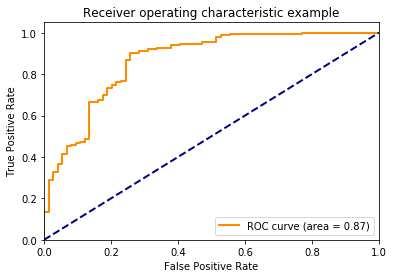

In [39]:
from sklearn.metrics import roc_curve,auc
from matplotlib import pyplot as plt

fpr,tpr,thresholds = roc_curve(y_val,y_val_proba[:,1],drop_intermediate=False)
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Trial 4

In [44]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss,accuracy_score,f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedShuffleSplit,GridSearchCV
from sklearn.metrics import make_scorer

# Cross validation of gradient boosted tree classifier
gbc = GradientBoostingClassifier(random_state=0,max_features=307)
scorer = make_scorer(log_loss,greater_is_better=False,needs_proba=True)


estimators_range = [1400,1500,1600,1800,2000]
lr_range = [0.05]
subsample_range = [0.20,0.25,0.30]
max_depth_range = [3]
param_grid = {'n_estimators':estimators_range,'learning_rate':lr_range,
             'subsample':subsample_range,'max_depth':max_depth_range}
cv = StratifiedShuffleSplit(n_splits=3,test_size = 0.2,random_state = 0)
grid = GridSearchCV(gbc,param_grid=param_grid,cv=cv,n_jobs=7,verbose=2,scoring=scorer)

grid.fit(X_train[:,importance_idx],y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))



Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] learning_rate=0.05, n_estimators=1400, subsample=0.2, max_depth=3 
[CV] learning_rate=0.05, n_estimators=1400, subsample=0.2, max_depth=3 
[CV] learning_rate=0.05, n_estimators=1400, subsample=0.2, max_depth=3 
[CV] learning_rate=0.05, n_estimators=1400, subsample=0.25, max_depth=3 
[CV] learning_rate=0.05, n_estimators=1400, subsample=0.25, max_depth=3 
[CV] learning_rate=0.05, n_estimators=1400, subsample=0.25, max_depth=3 
[CV] learning_rate=0.05, n_estimators=1400, subsample=0.3, max_depth=3 
[CV]  learning_rate=0.05, n_estimators=1400, subsample=0.2, max_depth=3, total=  11.2s
[CV] learning_rate=0.05, n_estimators=1400, subsample=0.3, max_depth=3 
[CV]  learning_rate=0.05, n_estimators=1400, subsample=0.25, max_depth=3, total=  13.0s
[CV] learning_rate=0.05, n_estimators=1400, subsample=0.3, max_depth=3 
[CV]  learning_rate=0.05, n_estimators=1400, subsample=0.3, max_depth=3, total=  13.6s
[CV] learning_rate=0.05, n

[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   57.9s


[CV]  learning_rate=0.05, n_estimators=1600, subsample=0.3, max_depth=3, total=  15.5s
[CV] learning_rate=0.05, n_estimators=1800, subsample=0.3, max_depth=3 
[CV]  learning_rate=0.05, n_estimators=1800, subsample=0.2, max_depth=3, total=  14.0s
[CV] learning_rate=0.05, n_estimators=1800, subsample=0.3, max_depth=3 
[CV]  learning_rate=0.05, n_estimators=1800, subsample=0.2, max_depth=3, total=  14.6s
[CV] learning_rate=0.05, n_estimators=2000, subsample=0.2, max_depth=3 
[CV]  learning_rate=0.05, n_estimators=1800, subsample=0.25, max_depth=3, total=  14.8s
[CV] learning_rate=0.05, n_estimators=2000, subsample=0.2, max_depth=3 
[CV]  learning_rate=0.05, n_estimators=1800, subsample=0.3, max_depth=3, total=  13.3s
[CV] learning_rate=0.05, n_estimators=2000, subsample=0.2, max_depth=3 
[CV]  learning_rate=0.05, n_estimators=1800, subsample=0.25, max_depth=3, total=  13.7s
[CV] learning_rate=0.05, n_estimators=2000, subsample=0.25, max_depth=3 
[CV]  learning_rate=0.05, n_estimators=1800

[Parallel(n_jobs=7)]: Done  45 out of  45 | elapsed:  1.6min finished


The best parameters are {'learning_rate': 0.05, 'n_estimators': 2000, 'subsample': 0.2, 'max_depth': 3} with a score of -0.08


In [45]:
import pandas as pd

results = pd.DataFrame(grid.cv_results_)
results['Mean_minus_STD']=results['mean_test_score']-results['std_test_score']
results.sort_values('Mean_minus_STD',inplace=True,ascending=False)
results.head(5)

/home/ubuntu/anaconda3/envs/DHSenv_3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ubuntu/anaconda3/envs/DHSenv_3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ubuntu/anaconda3/envs/DHSenv_3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, 

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,rank_test_score,...,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score,Mean_minus_STD
3,14.475955,0.011578,-0.076066,-0.000215,0.05,3,1500,0.2,"{'learning_rate': 0.05, 'n_estimators': 1500, ...",2,...,-0.000218,-0.086098,-0.000213,-0.100307,-0.000213,0.099774,0.000152,0.024919,0.000002,-0.100985
12,14.213747,0.010928,-0.075822,-0.000206,0.05,3,2000,0.2,"{'learning_rate': 0.05, 'n_estimators': 2000, ...",1,...,-0.000208,-0.085290,-0.000205,-0.101067,-0.000204,0.586978,0.001834,0.025377,0.000002,-0.101199
9,14.063009,0.010663,-0.076082,-0.000207,0.05,3,1800,0.2,"{'learning_rate': 0.05, 'n_estimators': 1800, ...",3,...,-0.000210,-0.085596,-0.000207,-0.101169,-0.000205,0.396221,0.001711,0.025279,0.000002,-0.101361
0,13.271949,0.012601,-0.076798,-0.000229,0.05,3,1400,0.2,"{'learning_rate': 0.05, 'n_estimators': 1400, ...",5,...,-0.000230,-0.086640,-0.000229,-0.101219,-0.000227,1.511291,0.000105,0.024948,0.000002,-0.101746
6,13.463253,0.009229,-0.076757,-0.000211,0.05,3,1600,0.2,"{'learning_rate': 0.05, 'n_estimators': 1600, ...",4,...,-0.000213,-0.086049,-0.000210,-0.102278,-0.000209,1.480285,0.001746,0.025493,0.000002,-0.102250


In [46]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss,accuracy_score,f1_score
from sklearn.metrics import precision_recall_fscore_support

# Retrain using best params
gbc = GradientBoostingClassifier(random_state=0,subsample=0.20,learning_rate=0.05,n_estimators=1500)
gbc.fit(X_train[:,importance_idx],y_train)

# Make predictions
y_val_pred = gbc.predict(X_val[:,importance_idx])
y_val_proba = gbc.predict_proba(X_val[:,importance_idx])
y_train_pred = gbc.predict(X_train[:,importance_idx])
y_train_proba = gbc.predict_proba(X_train[:,importance_idx])

# Validation scores
logl = log_loss(y_val,y_val_proba)
p,r,f,s = precision_recall_fscore_support(y_val,y_val_pred)
acc = accuracy_score(y_val,y_val_pred)
print("Validation Scores:")
print("Log-Loss: {}".format(logl))
print("Positive Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[1],r[1],f[1],s[1]))
print("Negative Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[0],r[0],f[0],s[0]))
print("Accuracy: {}\n".format(acc))

# Training Scores
logl = log_loss(y_train,y_train_proba)
p,r,f,s = precision_recall_fscore_support(y_train,y_train_pred)
acc = accuracy_score(y_train,y_train_pred)
print("Training Scores:")
print("Log-Loss: {}".format(logl))
print("Positive Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[1],r[1],f[1],s[1]))
print("Negative Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[0],r[0],f[0],s[0]))
print("Accuracy: {}".format(acc))

Validation Scores:
Log-Loss: 0.6197104402805726
Positive Label
Precision: 0.8263473053892215, Recall: 0.92, F1: 0.8706624605678233, Support: 150
Negative Label
Precision: 0.7894736842105263, Recall: 0.6081081081081081, F1: 0.6870229007633588, Support: 74
Accuracy: 0.8169642857142857

Training Scores:
Log-Loss: 0.00022442519545877725
Positive Label
Precision: 1.0, Recall: 1.0, F1: 1.0, Support: 544
Negative Label
Precision: 1.0, Recall: 1.0, F1: 1.0, Support: 544
Accuracy: 1.0


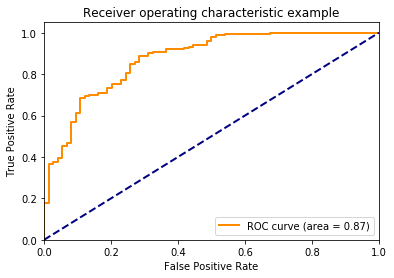

In [48]:
from sklearn.metrics import roc_curve,auc
from matplotlib import pyplot as plt

fpr,tpr,thresholds = roc_curve(y_val,y_val_proba[:,1],drop_intermediate=False)
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Trial 5

In [49]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss,accuracy_score,f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedShuffleSplit,GridSearchCV
from sklearn.metrics import make_scorer

# Cross validation of gradient boosted tree classifier
gbc = GradientBoostingClassifier(random_state=0,max_features=307)
scorer = make_scorer(log_loss,greater_is_better=False,needs_proba=True)


estimators_range = [1400,1500,1700,1900,2100]
lr_range = [0.05]
subsample_range = [0.10,0.15,0.20,0.25]
max_depth_range = [3]
param_grid = {'n_estimators':estimators_range,'learning_rate':lr_range,
             'subsample':subsample_range,'max_depth':max_depth_range}
cv = StratifiedShuffleSplit(n_splits=3,test_size = 0.2,random_state = 0)
grid = GridSearchCV(gbc,param_grid=param_grid,cv=cv,n_jobs=7,verbose=2,scoring=scorer)

grid.fit(X_train[:,importance_idx],y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))



Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] learning_rate=0.05, n_estimators=1400, subsample=0.1, max_depth=3 
[CV] learning_rate=0.05, n_estimators=1400, subsample=0.1, max_depth=3 
[CV] learning_rate=0.05, n_estimators=1400, subsample=0.1, max_depth=3 
[CV] learning_rate=0.05, n_estimators=1400, subsample=0.15, max_depth=3 
[CV] learning_rate=0.05, n_estimators=1400, subsample=0.15, max_depth=3 
[CV] learning_rate=0.05, n_estimators=1400, subsample=0.15, max_depth=3 
[CV] learning_rate=0.05, n_estimators=1400, subsample=0.2, max_depth=3 
[CV]  learning_rate=0.05, n_estimators=1400, subsample=0.1, max_depth=3, total=   6.6s
[CV] learning_rate=0.05, n_estimators=1400, subsample=0.2, max_depth=3 
[CV]  learning_rate=0.05, n_estimators=1400, subsample=0.1, max_depth=3, total=   9.3s
[CV] learning_rate=0.05, n_estimators=1400, subsample=0.2, max_depth=3 
[CV]  learning_rate=0.05, n_estimators=1400, subsample=0.1, max_depth=3, total=   9.4s
[CV] learning_rate=0.05, n_

[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   48.4s


[CV]  learning_rate=0.05, n_estimators=1700, subsample=0.15, max_depth=3, total=  13.6s
[CV] learning_rate=0.05, n_estimators=1700, subsample=0.25, max_depth=3 
[CV]  learning_rate=0.05, n_estimators=1700, subsample=0.15, max_depth=3, total=  13.8s
[CV] learning_rate=0.05, n_estimators=1700, subsample=0.25, max_depth=3 
[CV]  learning_rate=0.05, n_estimators=1700, subsample=0.15, max_depth=3, total=  13.7s
[CV] learning_rate=0.05, n_estimators=1900, subsample=0.1, max_depth=3 
[CV]  learning_rate=0.05, n_estimators=1700, subsample=0.2, max_depth=3, total=  13.1s
[CV]  learning_rate=0.05, n_estimators=1700, subsample=0.2, max_depth=3, total=  12.2s
[CV] learning_rate=0.05, n_estimators=1900, subsample=0.1, max_depth=3 
[CV] learning_rate=0.05, n_estimators=1900, subsample=0.1, max_depth=3 
[CV]  learning_rate=0.05, n_estimators=1700, subsample=0.2, max_depth=3, total=  14.5s
[CV] learning_rate=0.05, n_estimators=1900, subsample=0.15, max_depth=3 
[CV]  learning_rate=0.05, n_estimators=1

[Parallel(n_jobs=7)]: Done  60 out of  60 | elapsed:  1.8min finished


The best parameters are {'learning_rate': 0.05, 'n_estimators': 2100, 'subsample': 0.2, 'max_depth': 3} with a score of -0.08


In [50]:
import pandas as pd

results = pd.DataFrame(grid.cv_results_)
results['Mean_minus_STD']=results['mean_test_score']-results['std_test_score']
results.sort_values('Mean_minus_STD',inplace=True,ascending=False)
results.head(5)

/home/ubuntu/anaconda3/envs/DHSenv_3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ubuntu/anaconda3/envs/DHSenv_3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ubuntu/anaconda3/envs/DHSenv_3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, 

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,rank_test_score,...,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score,Mean_minus_STD
6,13.653617,0.011632,-0.076066,-0.000215,0.05,3,1500,0.2,"{'learning_rate': 0.05, 'n_estimators': 1500, ...",3,...,-0.000218,-0.086098,-0.000213,-0.100307,-0.000213,1.203729,0.000112,0.024919,0.000002,-0.100985
18,12.940099,0.009612,-0.075743,-0.000205,0.05,3,2100,0.2,"{'learning_rate': 0.05, 'n_estimators': 2100, ...",1,...,-0.000207,-0.085424,-0.000205,-0.100900,-0.000204,1.832989,0.001907,0.025431,0.000001,-0.101174
14,13.653267,0.010859,-0.075932,-0.000207,0.05,3,1900,0.2,"{'learning_rate': 0.05, 'n_estimators': 1900, ...",2,...,-0.000208,-0.085529,-0.000207,-0.100929,-0.000204,0.316417,0.001777,0.025257,0.000002,-0.101189
2,12.465597,0.011843,-0.076798,-0.000229,0.05,3,1400,0.2,"{'learning_rate': 0.05, 'n_estimators': 1400, ...",5,...,-0.000230,-0.086640,-0.000229,-0.101219,-0.000227,0.828779,0.000679,0.024948,0.000002,-0.101746
10,13.251170,0.010663,-0.076396,-0.000208,0.05,3,1700,0.2,"{'learning_rate': 0.05, 'n_estimators': 1700, ...",4,...,-0.000211,-0.086266,-0.000208,-0.101700,-0.000206,0.929715,0.001739,0.025657,0.000002,-0.102054


Validation data class proportions are different than training data proportions.

In [23]:
print("{} Total Samples.".format(len(y_val)))
print("{0} Total positives, corresponding to {1:.1f}% of the data".format(sum(y_val),sum(y_val)*100/len(y_val)))


224 Total Samples.
150.0 Total positives, corresponding to 67.0% of the data


## Trial 5 (early stopping)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss,accuracy_score,f1_score
from sklearn.metrics import precision_recall_fscore_support

# Retrain using best params
gbc = GradientBoostingClassifier(random_state=0,subsample=0.20,learning_rate=0.05,n_estimators=1500)
gbc.fit(X_train[:,importance_idx],y_train)

# Make predictions
y_val_pred = gbc.predict(X_val[:,importance_idx])
y_val_proba = gbc.predict_proba(X_val[:,importance_idx])
y_train_pred = gbc.predict(X_train[:,importance_idx])
y_train_proba = gbc.predict_proba(X_train[:,importance_idx])

# Validation scores
logl = log_loss(y_val,y_val_proba)
p,r,f,s = precision_recall_fscore_support(y_val,y_val_pred)
acc = accuracy_score(y_val,y_val_pred)
print("Validation Scores:")
print("Log-Loss: {}".format(logl))
print("Positive Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[1],r[1],f[1],s[1]))
print("Negative Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[0],r[0],f[0],s[0]))
print("Accuracy: {}\n".format(acc))

# Training Scores
logl = log_loss(y_train,y_train_proba)
p,r,f,s = precision_recall_fscore_support(y_train,y_train_pred)
acc = accuracy_score(y_train,y_train_pred)
print("Training Scores:")
print("Log-Loss: {}".format(logl))
print("Positive Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[1],r[1],f[1],s[1]))
print("Negative Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[0],r[0],f[0],s[0]))
print("Accuracy: {}".format(acc))

In [ ]:
from sklearn.metrics import roc_curve,auc
from matplotlib import pyplot as plt

fpr,tpr,thresholds = roc_curve(y_val,y_val_proba[:,1],drop_intermediate=False)
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Feature Importance

In [3]:
#Store results so that we don't lose this data again
with h5py.File("importance_idx.hdf5","r") as f:
    importance_idx = f['importance_idx'].value

In [41]:
import pandas as pd

# Information about feature extraction process
num_features = X_train.shape[1]
features_per_angle = num_features // 16
layer_size = [256,288,288,768,768,768,768,768,1280,2048]
layer_bins = [0]
for size in layer_size:
    layer_bins.append(size+layer_bins[-1])
layer_labels = [0,1,2,3,4,5,6,7,8,9]

# Create dataframe with feature importances and other information about feature provenance
feature_n = np.arange(0,num_features)
df = pd.DataFrame({'FeatureN':feature_n,'Importance':gbc.feature_importances_/gbc.feature_importances_.max()})
df['Angle'] = df['FeatureN']//features_per_angle
df['LayerN'] = pd.cut(df['FeatureN']%sum(layer_size),layer_bins,labels=layer_labels,right=False,include_lowest=True)

df.sort_values('Importance',inplace=True,ascending=False)
df.head(20)

,FeatureN,Importance,Angle,LayerN
35,35,1.000000,0,0
389,389,0.904860,9,1
282,282,0.836668,6,1
671,671,0.809843,15,2
229,229,0.751167,5,0
442,442,0.591243,10,1
373,373,0.585241,8,1
506,506,0.578309,12,1
625,625,0.561938,14,2
592,592,0.561701,14,2


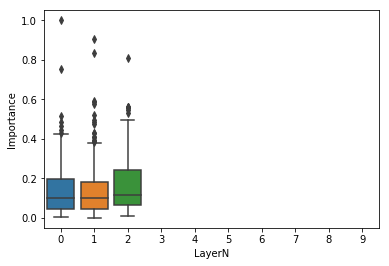

In [42]:
import seaborn as sns
% matplotlib inline

df_no_zero = df.loc[lambda df: df.Importance > 0 ,:]
sns.boxplot(x="LayerN",y="Importance",data=df_no_zero)

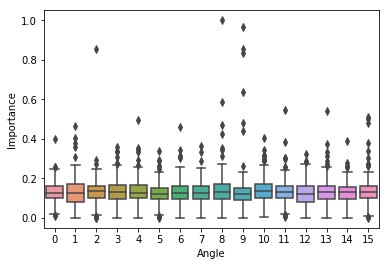

In [7]:
sns.boxplot(x="Angle",y="Importance",data=df_no_zero)

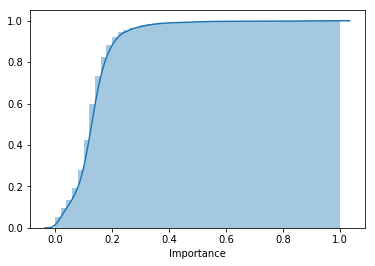

In [8]:
ax = sns.distplot(df_no_zero.Importance,kde=True,kde_kws={'cumulative':True},hist_kws={'cumulative':True})

In [9]:
df_top_20perc = df.loc[lambda df:df.Importance>0.18,:]
df_top_20perc.describe()

,FeatureN,Importance,Angle
count,351.000000,351.000000,351.000000
mean,64884.179487,0.250784,7.598291
std,36785.343573,0.107418,4.591408
min,285.000000,0.180087,0.000000
25%,31942.000000,0.194933,3.500000
50%,66347.000000,0.214801,8.000000
75%,96443.000000,0.263131,12.000000
max,126906.000000,1.000000,15.000000


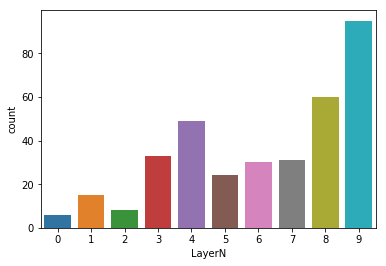

In [10]:
sns.countplot(x="LayerN",data=df_top_20perc)

We should normalize the count plot by the number of features from each layer. 

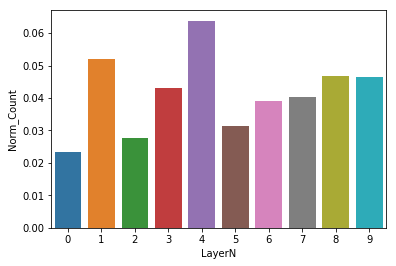

In [18]:
layer_size = [256,288,288,768,768,768,768,768,1280,2048]
counts = df_top_20perc.groupby('LayerN').count()

counts['N_Features'] = layer_size
counts['Norm_Count'] = counts['Angle']/counts['N_Features']

sns.barplot(x=counts.index,y="Norm_Count",data=counts)


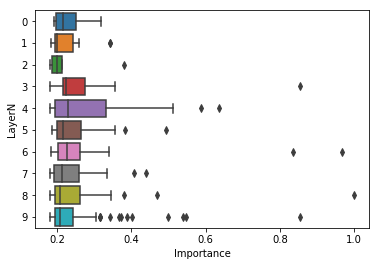

In [13]:
ax = sns.boxplot(x="Importance",y="LayerN",data=df_top_20perc)
#ax.set_xlim(0.0002,0.0015)

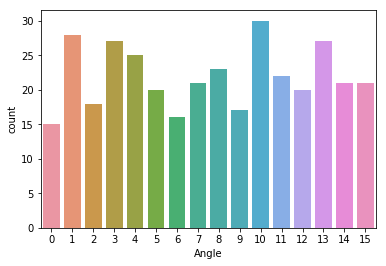

In [14]:
sns.countplot(x="Angle",data=df_top_20perc)

The graphs above yield surprising results. The relevance of the layers from the neural net does not monotonically decrease. While layers 1 and 4 dominate with respect to their participation among the top 20% most important features, the importance of features from higher layers seems to be monotonically increasing after layer 4. In the future, we might want to extract features from layer 10 and use a greater spatial resolution for the most important layers (1,3,4 and perhaps 9 and 10)--in the extraction process we used global max pooling.


Running PCA...


[[<matplotlib.axis.XTick at 0x7fbe90b23780>,

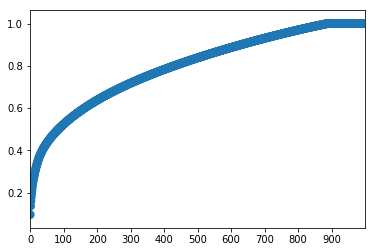

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
% matplotlib inline

# Scoring and scaling
scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)

# PCA Decomposition to make parameter tuning faster
print("Running PCA...")
pca = PCA(n_components=1000,random_state=0)
pca.fit(X_train)
X_t = pca.transform(X_train)

# Show that most of the variance is captured by first 1000 components
cum_explained_ratio = np.cumsum(pca.explained_variance_ratio_)
component = np.arange(0,len(cum_explained_ratio))

ax = sns.pointplot(component,cum_explained_ratio)
ax.set(xticks=np.arange(0,len(cum_explained_ratio),100),xticklabels=np.arange(0,len(cum_explained_ratio),100))

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,f1_score,precision_recall_fscore_support,make_scorer

# Scorer
scorer = make_scorer(accuracy_score)
scaler = StandardScaler()
# Paramter search space
C_range = np.logspace(-2,10,4)
gamma_range = np.logspace(-9,3,4)

# Cross validation
param_grid = dict(gamma=gamma_range,C=C_range)
cv = StratifiedShuffleSplit(n_splits=3,test_size = 0.2,random_state = 0)
grid = GridSearchCV(SVC(verbose=2),param_grid=param_grid,cv=cv,n_jobs=3,verbose=2,scoring=scorer)

grid.fit(scaler.fit_transform(X_train[:,importance_idx],y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

# Predictions
y_train_pred = grid.predict(scaler.transform(X_train[:,importance_idx]))
y_val_pred = grid.predict(scaler.transform(X_val[:,importance_idx]))

# Validation scores
p,r,f,s = precision_recall_fscore_support(y_val,y_val_pred)
acc = accuracy_score(y_val,y_val_pred)
print("Validation Scores:")
print("Positive Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[1],r[1],f[1],s[1]))
print("Negative Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[0],r[0],f[0],s[0]))
print("Accuracy: {}\n".format(acc))

# Training Scores
p,r,f,s = precision_recall_fscore_support(y_train,y_train_pred)
acc = accuracy_score(y_train,y_train_pred)
print("Training Scores:")
print("Positive Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[1],r[1],f[1],s[1]))
print("Negative Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[0],r[0],f[0],s[0]))
print("Accuracy: {}".format(acc))

SyntaxError: invalid syntax (<ipython-input-51-7185a7894310>, line 21)

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,f1_score,precision_recall_fscore_support,make_scorer

# Scorer
scorer = make_scorer(accuracy_score)

# Paramter search space
C_range = np.linspace(1e5,1e7,10)
gamma_range = np.logspace(-12,-8,10)

# Cross validation
param_grid = dict(gamma=gamma_range,C=C_range)
cv = StratifiedShuffleSplit(n_splits=3,test_size = 0.2,random_state = 0)
grid = GridSearchCV(SVC(verbose=2),param_grid=param_grid,cv=cv,n_jobs=10,verbose=2,scoring=scorer)

grid.fit(X_t,y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

# Predictions
y_train_pred = grid.predict(X_t)
y_val_pred = grid.predict(pca.transform(scaler.transform(X_val)))

# Validation scores
p,r,f,s = precision_recall_fscore_support(y_val,y_val_pred)
acc = accuracy_score(y_val,y_val_pred)
print("Validation Scores:")
print("Positive Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[1],r[1],f[1],s[1]))
print("Negative Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[0],r[0],f[0],s[0]))
print("Accuracy: {}\n".format(acc))

# Training Scores
p,r,f,s = precision_recall_fscore_support(y_train,y_train_pred)
acc = accuracy_score(y_train,y_train_pred)
print("Training Scores:")
print("Positive Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[1],r[1],f[1],s[1]))
print("Negative Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[0],r[0],f[0],s[0]))
print("Accuracy: {}".format(acc))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] gamma=1e-12, C=100000.0 .........................................
[CV] gamma=1e-12, C=100000.0 .........................................
[CV] gamma=1e-12, C=100000.0 .........................................
[CV] gamma=2.78255940221e-12, C=100000.0 .............................
[CV] gamma=2.78255940221e-12, C=100000.0 .............................
[CV] gamma=2.78255940221e-12, C=100000.0 .............................
[CV] gamma=7.74263682681e-12, C=100000.0 .............................
[CV] gamma=7.74263682681e-12, C=100000.0 .............................
[CV] gamma=7.74263682681e-12, C=100000.0 .............................
[CV] gamma=2.15443469003e-11, C=100000.0 .............................
[LibSVM][CV] .............. gamma=7.74263682681e-12, C=100000.0, total=   1.6s
[CV] gamma=2.15443469003e-11, C=100000.0 .............................
[LibSVM][CV] .......................... gamma=1e-12, C=100000.0, total=   2.1

[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    8.5s


[LibSVM][CV] .............. gamma=1.29154966501e-09, C=100000.0, total=   1.5s
[CV] gamma=1e-12, C=1200000.0 ........................................
[LibSVM][CV] .............. gamma=1.29154966501e-09, C=100000.0, total=   1.7s
[CV] gamma=1e-12, C=1200000.0 ........................................
[LibSVM][CV] .............. gamma=1.29154966501e-09, C=100000.0, total=   1.6s
[CV] gamma=2.78255940221e-12, C=1200000.0 ............................
[LibSVM][CV] ............... gamma=3.5938136638e-09, C=100000.0, total=   1.6s
[CV] gamma=2.78255940221e-12, C=1200000.0 ............................
[LibSVM][CV] ............... gamma=3.5938136638e-09, C=100000.0, total=   1.6s
[CV] gamma=2.78255940221e-12, C=1200000.0 ............................
[LibSVM][CV] .......................... gamma=1e-08, C=100000.0, total=   1.5s
[CV] gamma=7.74263682681e-12, C=1200000.0 ............................
[LibSVM][CV] ............... gamma=3.5938136638e-09, C=100000.0, total=   1.8s
[CV] gamma=7.74263682

[LibSVM][CV] .............. gamma=1.6681005372e-10, C=2300000.0, total=   1.5s
[CV] gamma=3.5938136638e-09, C=2300000.0 .............................
[LibSVM][CV] .............. gamma=1.6681005372e-10, C=2300000.0, total=   1.4s
[CV] gamma=1e-08, C=2300000.0 ........................................
[LibSVM][CV] ............. gamma=4.64158883361e-10, C=2300000.0, total=   1.5s
[CV] gamma=1e-08, C=2300000.0 ........................................
[LibSVM][CV] ............. gamma=4.64158883361e-10, C=2300000.0, total=   1.6s
[CV] gamma=1e-08, C=2300000.0 ........................................
[LibSVM][CV] ............. gamma=1.29154966501e-09, C=2300000.0, total=   1.4s
[CV] gamma=1e-12, C=3400000.0 ........................................
[LibSVM][CV] ............. gamma=1.29154966501e-09, C=2300000.0, total=   1.9s
[CV] gamma=1e-12, C=3400000.0 ........................................
[LibSVM][CV] ............. gamma=4.64158883361e-10, C=2300000.0, total=   2.1s
[CV] gamma=1e-12, C=3

[LibSVM][CV] ............. gamma=2.15443469003e-11, C=4500000.0, total=   1.7s
[CV] gamma=1.29154966501e-09, C=4500000.0 ............................
[LibSVM][CV] ............. gamma=5.99484250319e-11, C=4500000.0, total=   1.7s
[CV] gamma=1.29154966501e-09, C=4500000.0 ............................
[LibSVM][CV] ............. gamma=5.99484250319e-11, C=4500000.0, total=   1.5s
[CV] gamma=1.29154966501e-09, C=4500000.0 ............................
[LibSVM][CV] .............. gamma=1.6681005372e-10, C=4500000.0, total=   1.2s
[CV] gamma=3.5938136638e-09, C=4500000.0 .............................
[LibSVM][CV] ............. gamma=5.99484250319e-11, C=4500000.0, total=   1.8s
[CV] gamma=3.5938136638e-09, C=4500000.0 .............................
[LibSVM][CV] .............. gamma=1.6681005372e-10, C=4500000.0, total=   1.8s
[CV] gamma=3.5938136638e-09, C=4500000.0 .............................
[LibSVM][CV] ............. gamma=4.64158883361e-10, C=4500000.0, total=   1.7s
[CV] gamma=1e-08, C=4

[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   40.8s


[CV] gamma=2.78255940221e-12, C=5600000.0 ............................
[LibSVM][CV] .............. gamma=3.5938136638e-09, C=4500000.0, total=   1.7s
[CV] gamma=2.78255940221e-12, C=5600000.0 ............................
[LibSVM][CV] ......................... gamma=1e-12, C=5600000.0, total=   0.9s
[CV] gamma=7.74263682681e-12, C=5600000.0 ............................
[LibSVM][CV] .............. gamma=3.5938136638e-09, C=4500000.0, total=   1.3s
[CV] gamma=7.74263682681e-12, C=5600000.0 ............................
[LibSVM][CV] ......................... gamma=1e-08, C=4500000.0, total=   1.6s
[CV] gamma=7.74263682681e-12, C=5600000.0 ............................
[LibSVM][CV] ......................... gamma=1e-08, C=4500000.0, total=   1.7s
[CV] gamma=2.15443469003e-11, C=5600000.0 ............................
[LibSVM][CV] ......................... gamma=1e-12, C=5600000.0, total=   1.1s
[CV] gamma=2.15443469003e-11, C=5600000.0 ............................
[LibSVM][CV] ............. ga

[CV] gamma=1e-08, C=6700000.0 ........................................
[LibSVM][CV] ............. gamma=4.64158883361e-10, C=6700000.0, total=   2.0s
[CV] gamma=1e-12, C=7800000.0 ........................................
[LibSVM][CV] ............. gamma=1.29154966501e-09, C=6700000.0, total=   1.5s
[CV] gamma=1e-12, C=7800000.0 ........................................
[LibSVM][CV] ............. gamma=1.29154966501e-09, C=6700000.0, total=   1.7s
[CV] gamma=1e-12, C=7800000.0 ........................................
[LibSVM][CV] .............. gamma=3.5938136638e-09, C=6700000.0, total=   1.3s
[CV] gamma=2.78255940221e-12, C=7800000.0 ............................
[LibSVM][CV] ............. gamma=1.29154966501e-09, C=6700000.0, total=   2.1s
[CV] gamma=2.78255940221e-12, C=7800000.0 ............................
[LibSVM][CV] .............. gamma=3.5938136638e-09, C=6700000.0, total=   1.9s
[CV] gamma=2.78255940221e-12, C=7800000.0 ............................
[LibSVM][CV] ................

[CV] gamma=3.5938136638e-09, C=8900000.0 .............................
[LibSVM][CV] .............. gamma=1.6681005372e-10, C=8900000.0, total=   1.6s
[CV] gamma=3.5938136638e-09, C=8900000.0 .............................
[LibSVM][CV] .............. gamma=1.6681005372e-10, C=8900000.0, total=   1.4s
[CV] gamma=3.5938136638e-09, C=8900000.0 .............................
[LibSVM][CV] .............. gamma=1.6681005372e-10, C=8900000.0, total=   1.7s
[CV] gamma=1e-08, C=8900000.0 ........................................
[LibSVM][CV] ............. gamma=4.64158883361e-10, C=8900000.0, total=   1.9s
[CV] gamma=1e-08, C=8900000.0 ........................................
[LibSVM][CV] ............. gamma=1.29154966501e-09, C=8900000.0, total=   1.3s
[CV] gamma=1e-08, C=8900000.0 ........................................
[LibSVM][CV] .............. gamma=3.5938136638e-09, C=8900000.0, total=   1.1s
[CV] gamma=1e-12, C=10000000.0 .......................................
[LibSVM][CV] ............. ga

[Parallel(n_jobs=10)]: Done 300 out of 300 | elapsed:  1.3min finished


[LibSVM]The best parameters are {'gamma': 2.1544346900318868e-11, 'C': 1200000.0} with a score of 0.90
Validation Scores:
Positive Label
Precision: 0.8245614035087719, Recall: 0.94, F1: 0.8785046728971964, Support: 150
Negative Label
Precision: 0.8301886792452831, Recall: 0.5945945945945946, F1: 0.6929133858267718, Support: 74
Accuracy: 0.8258928571428571

Training Scores:
Positive Label
Precision: 1.0, Recall: 1.0, F1: 1.0, Support: 544
Negative Label
Precision: 1.0, Recall: 1.0, F1: 1.0, Support: 544
Accuracy: 1.0


In [35]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss,accuracy_score,f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedShuffleSplit,GridSearchCV
from sklearn.metrics import make_scorer

# Cross validation of gradient boosted tree classifier
gbc = GradientBoostingClassifier(random_state=0,max_features="sqrt")
scorer = make_scorer(accuracy_score)

estimators_range = [250,500,750,1000]
lr_range = [0.1,0.2,0.4]
subsample_range = [0.60,0.75,0.9,1]
max_depth_range = [3]
param_grid = {'n_estimators':estimators_range,'learning_rate':lr_range,
             'subsample':subsample_range,'max_depth':max_depth_range}
cv = StratifiedShuffleSplit(n_splits=3,test_size = 0.2,random_state = 0)
grid = GridSearchCV(gbc,param_grid=param_grid,cv=cv,n_jobs=10,verbose=2,scoring=scorer)

grid.fit(X_t,y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))



Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] max_depth=3, n_estimators=250, learning_rate=0.1, subsample=0.6 .
[CV] max_depth=3, n_estimators=250, learning_rate=0.1, subsample=0.6 .
[CV] max_depth=3, n_estimators=250, learning_rate=0.1, subsample=0.6 .
[CV] max_depth=3, n_estimators=250, learning_rate=0.1, subsample=0.75 
[CV] max_depth=3, n_estimators=250, learning_rate=0.1, subsample=0.75 
[CV] max_depth=3, n_estimators=250, learning_rate=0.1, subsample=0.75 
[CV] max_depth=3, n_estimators=250, learning_rate=0.1, subsample=0.9 .
[CV] max_depth=3, n_estimators=250, learning_rate=0.1, subsample=0.9 .
[CV] max_depth=3, n_estimators=250, learning_rate=0.1, subsample=0.9 .
[CV] max_depth=3, n_estimators=250, learning_rate=0.1, subsample=1 ...
[CV]  max_depth=3, n_estimators=250, learning_rate=0.1, subsample=0.6, total=   1.1s
[CV] max_depth=3, n_estimators=250, learning_rate=0.1, subsample=1 ...
[CV]  max_depth=3, n_estimators=250, learning_rate=0.1, subsample=0.6, t

[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.3s


[CV]  max_depth=3, n_estimators=500, learning_rate=0.1, subsample=1, total=   3.5s
[CV] max_depth=3, n_estimators=750, learning_rate=0.1, subsample=0.9 .
[CV]  max_depth=3, n_estimators=500, learning_rate=0.1, subsample=1, total=   2.7s
[CV] max_depth=3, n_estimators=750, learning_rate=0.1, subsample=0.9 .
[CV]  max_depth=3, n_estimators=500, learning_rate=0.1, subsample=1, total=   2.9s
[CV] max_depth=3, n_estimators=750, learning_rate=0.1, subsample=1 ...
[CV]  max_depth=3, n_estimators=750, learning_rate=0.1, subsample=0.6, total=   3.6s
[CV] max_depth=3, n_estimators=750, learning_rate=0.1, subsample=1 ...
[CV]  max_depth=3, n_estimators=750, learning_rate=0.1, subsample=0.6, total=   3.4s
[CV] max_depth=3, n_estimators=750, learning_rate=0.1, subsample=1 ...
[CV]  max_depth=3, n_estimators=750, learning_rate=0.1, subsample=0.6, total=   4.3s
[CV] max_depth=3, n_estimators=1000, learning_rate=0.1, subsample=0.6 
[CV]  max_depth=3, n_estimators=750, learning_rate=0.1, subsample=0.75

[CV] max_depth=3, n_estimators=750, learning_rate=0.2, subsample=1 ...
[CV]  max_depth=3, n_estimators=500, learning_rate=0.2, subsample=1, total=   2.7s
[CV]  max_depth=3, n_estimators=750, learning_rate=0.2, subsample=0.6, total=   2.4s
[CV] max_depth=3, n_estimators=1000, learning_rate=0.2, subsample=0.6 
[CV] max_depth=3, n_estimators=1000, learning_rate=0.2, subsample=0.6 
[CV]  max_depth=3, n_estimators=750, learning_rate=0.2, subsample=0.75, total=   2.3s
[CV] max_depth=3, n_estimators=1000, learning_rate=0.2, subsample=0.6 
[CV]  max_depth=3, n_estimators=750, learning_rate=0.2, subsample=0.75, total=   2.6s
[CV] max_depth=3, n_estimators=1000, learning_rate=0.2, subsample=0.75 
[CV]  max_depth=3, n_estimators=750, learning_rate=0.2, subsample=0.9, total=   2.6s
[CV] max_depth=3, n_estimators=1000, learning_rate=0.2, subsample=0.75 
[CV]  max_depth=3, n_estimators=750, learning_rate=0.2, subsample=0.9, total=   2.3s
[CV] max_depth=3, n_estimators=1000, learning_rate=0.2, subsam

[CV] max_depth=3, n_estimators=1000, learning_rate=0.4, subsample=0.75 
[CV]  max_depth=3, n_estimators=750, learning_rate=0.4, subsample=1, total=   1.6s
[CV] max_depth=3, n_estimators=1000, learning_rate=0.4, subsample=0.75 
[CV]  max_depth=3, n_estimators=750, learning_rate=0.4, subsample=0.9, total=   1.8s
[CV]  max_depth=3, n_estimators=750, learning_rate=0.4, subsample=0.9, total=   1.6s
[CV] max_depth=3, n_estimators=1000, learning_rate=0.4, subsample=0.9 
[CV] max_depth=3, n_estimators=1000, learning_rate=0.4, subsample=0.9 
[CV]  max_depth=3, n_estimators=750, learning_rate=0.4, subsample=1, total=   1.3s
[CV] max_depth=3, n_estimators=1000, learning_rate=0.4, subsample=0.9 
[CV]  max_depth=3, n_estimators=750, learning_rate=0.4, subsample=1, total=   1.6s
[CV] max_depth=3, n_estimators=1000, learning_rate=0.4, subsample=1 ..
[CV]  max_depth=3, n_estimators=1000, learning_rate=0.4, subsample=0.75, total=   1.9s
[CV] max_depth=3, n_estimators=1000, learning_rate=0.4, subsample=

[Parallel(n_jobs=10)]: Done 144 out of 144 | elapsed:   34.3s finished


The best parameters are {'max_depth': 3, 'n_estimators': 500, 'subsample': 1, 'learning_rate': 0.2} with a score of 0.89


In [40]:
gbc = GradientBoostingClassifier(random_state=0,max_features=100,max_depth=3,n_estimators=500,learning_rate=0.2,subsample=0.5)
gbc.fit(X_t,y_train)

# Predictions
y_train_pred = gbc.predict(X_t)
y_train_proba = gbc.predict_proba(X_t)
y_val_pred = gbc.predict(pca.transform(scaler.transform(X_val)))
y_val_proba = gbc.predict_proba(pca.transform(scaler.transform(X_val)))

# Validation scores
logl = log_loss(y_val,y_val_proba)
p,r,f,s = precision_recall_fscore_support(y_val,y_val_pred)
acc = accuracy_score(y_val,y_val_pred)
print("Validation Scores:")
print("Log-Loss: {}".format(logl))
print("Positive Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[1],r[1],f[1],s[1]))
print("Negative Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[0],r[0],f[0],s[0]))
print("Accuracy: {}\n".format(acc))

# Training Scores
logl = log_loss(y_train,y_train_proba)
p,r,f,s = precision_recall_fscore_support(y_train,y_train_pred)
acc = accuracy_score(y_train,y_train_pred)
print("Training Scores:")
print("Log-Loss: {}".format(logl))
print("Positive Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[1],r[1],f[1],s[1]))
print("Negative Label")
print("Precision: {}, Recall: {}, F1: {}, Support: {}".format(p[0],r[0],f[0],s[0]))
print("Accuracy: {}".format(acc))

Validation Scores:
Log-Loss: 1.7328873494310812
Positive Label
Precision: 0.0, Recall: 0.0, F1: 0.0, Support: 150
Negative Label
Precision: 0.33035714285714285, Recall: 1.0, F1: 0.4966442953020134, Support: 74
Accuracy: 0.33035714285714285

Training Scores:
Log-Loss: 0.000269915325930252
Positive Label
Precision: 1.0, Recall: 1.0, F1: 1.0, Support: 544
Negative Label
Precision: 1.0, Recall: 1.0, F1: 1.0, Support: 544
Accuracy: 1.0


/home/ubuntu/anaconda3/envs/DHSenv_3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fit model for perplexity 2.
Fit model for perplexity 5.
Fit model for perplexity 30.
Fit model for perplexity 50.
Fit model for perplexity 100.


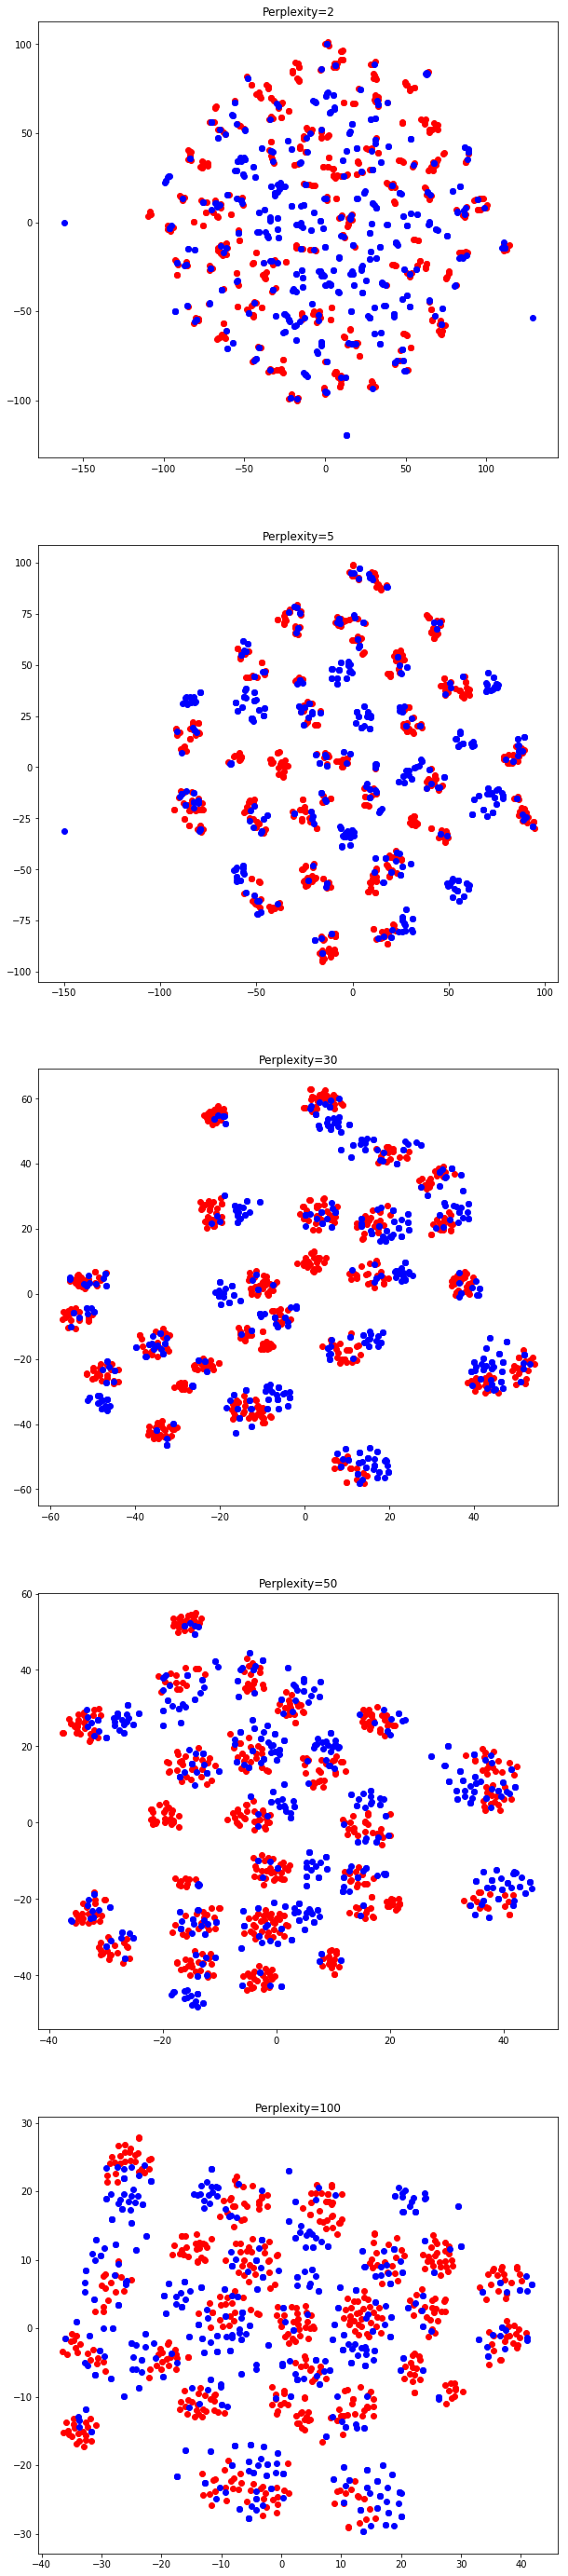

In [37]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
% matplotlib inline


perplexity = [2,5,30,50,100]

fig, axes = plt.subplots(5,1,figsize=(10,50))

red = y_train == 1
blue = y_train == 0

i = 0
for p in perplexity:
    # Fit t-SNE
    tsne = TSNE(perplexity = p, random_state = 0)
    X_tsne = tsne.fit_transform(X_t)
    print("Fit model for perplexity {}.".format(p))
    
    # Plot
    ax = axes[i]
    ax.set_title("Perplexity=%d" % p)
    ax.scatter(X_tsne[red,0],X_tsne[red,1],c='r')
    ax.scatter(X_tsne[blue,0],X_tsne[blue,1],c='b')
    
    i+=1
    
    

Fit model for perplexity 10.
Fit model for perplexity 20.
Fit model for perplexity 50.
Fit model for perplexity 75.
Fit model for perplexity 200.


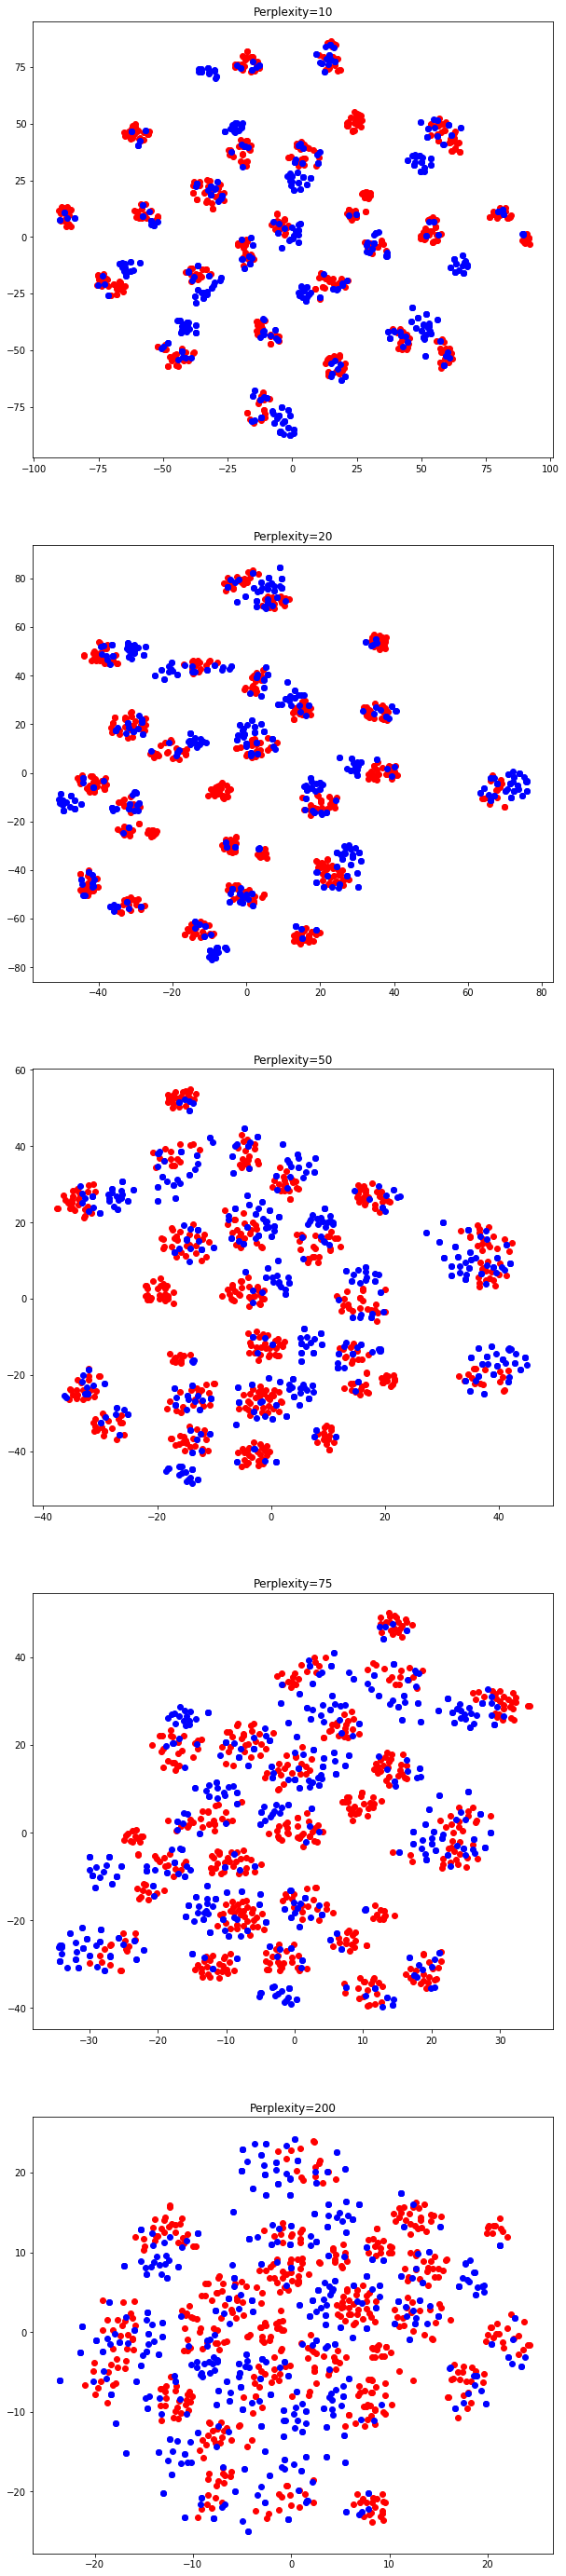

In [39]:

perplexity = [10,20,50,75,200]

fig, axes = plt.subplots(5,1,figsize=(10,50))

red = y_train == 1
blue = y_train == 0

i = 0
for p in perplexity:
    # Fit t-SNE
    tsne = TSNE(perplexity = p, random_state = 0)
    X_tsne = tsne.fit_transform(X_t)
    print("Fit model for perplexity {}.".format(p))
    
    # Plot
    ax = axes[i]
    ax.set_title("Perplexity=%d" % p)
    ax.scatter(X_tsne[red,0],X_tsne[red,1],c='r')
    ax.scatter(X_tsne[blue,0],X_tsne[blue,1],c='b')
    
    i+=1
    
    